In [ ]:
import torch, sys
print("Python:", sys.version)
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

!pip -q install opencv-python pycocotools matplotlib tqdm
!pip -q install 'git+https://github.com/facebookresearch/detectron2.git'

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Torch: 2.9.0+cu128
CUDA available: True
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.9/88.9 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.8/269.8 kB 27.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

from pathlib import Path
import os, json, glob, random, torch, math
import numpy as np
from PIL import Image

import cv2
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog, transforms as T, detection_utils as d2_utils, build_detection_train_loader
import copy

from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.evaluation import COCOEvaluator

from tqdm import tqdm
import matplotlib.pyplot as plt

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/MyDrive/Maestria/Proyecto integrador/Proyecto IA: Anaqueles frios/Data/"

IMG_DIR = Path(data_path + "unfisheye_data")
ANN_PATH = Path(data_path + "annotations/all_annotations.json")

IMAGES_DIR = data_path + "unfisheye_data"
ANN_PIXEL_JSON = data_path + "annotations/all_annotations.json"
ANN_NORM_JSON  = data_path + "annotations/all_annotations.normalized.json"

OUT_DIR = os.path.join(data_path, "detectron2_keypointrcnn") # Actualizar este folder en cada nueva ejecución completa de este notebook
os.makedirs(OUT_DIR, exist_ok=True)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print("IMAGES_DIR:", IMAGES_DIR)
print("OUT_DIR:", OUT_DIR)

IMAGES_DIR: /content/drive/MyDrive/Maestria/Proyecto integrador/Proyecto IA: Anaqueles frios/Data/unfisheye_data
OUT_DIR: /content/drive/MyDrive/Maestria/Proyecto integrador/Proyecto IA: Anaqueles frios/Data/detectron2_keypointrcnn


## Cargamos anotaciones

In [ ]:
def load_annotations(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    assert isinstance(data, list) and len(data) > 0
    return data

def image_size_from_disk(img_path):
    with Image.open(img_path) as im:
        w, h = im.size
    return w, h

def order_corners_tl_tr_br_bl(pts):
    pts = np.array(pts, dtype=np.float32)
    s = pts.sum(axis=1)          # x+y
    d = pts[:, 0] - pts[:, 1]    # x-y
    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]
    tr = pts[np.argmax(d)]
    bl = pts[np.argmin(d)]
    return np.stack([tl, tr, br, bl], axis=0)

def doors_left_to_right_key(door_vertices_xy):
    xs = [p[0] for p in door_vertices_xy]
    return float(np.mean(xs))

anns = load_annotations(ANN_PIXEL_JSON)
print("Ejemplo coordinate_space:", anns[0].get("coordinate_space"))

Ejemplo coordinate_space: pixel


## Construimos dataset Detectron2

In [ ]:
KEYPOINT_NAMES = ["tl", "tr", "br", "bl"]
KEYPOINT_FLIP_MAP = [("tl","tr"), ("bl","br")]

def build_detectron2_records(anns, images_dir, max_doors=4):
    records = []
    missing = 0

    for idx, item in enumerate(anns):
        rel_path = item["image_path"]
        img_path = os.path.join(images_dir, rel_path)
        if not os.path.exists(img_path):
            missing += 1
            continue


        w_json, h_json = int(item["width"]), int(item["height"])
        w, h = image_size_from_disk(img_path)
        if (w, h) != (w_json, h_json):
            print(f"[WARN] size mismatch {rel_path}: JSON {(w_json,h_json)} vs disk {(w,h)}; usando disk.")

        coord_space = item.get("coordinate_space", "pixel").lower()

        annos = []
        doors = item.get("doors", [])
        doors = [d for d in doors if d.get("is_valid", True)]

        door_xy_list = []
        for d in doors:
            verts = d["vertices"]
            if coord_space == "normalized":
                verts_xy = [[float(x)*w, float(y)*h] for x,y in verts]
            else:
                verts_xy = [[float(x), float(y)] for x,y in verts]
            ordered = order_corners_tl_tr_br_bl(verts_xy)
            door_xy_list.append((d.get("door_id", None), ordered))

        # Validamos si hay más de 4, tomar las 4 más a la izquierda
        if len(door_xy_list) > max_doors:
            door_xy_list = sorted(door_xy_list, key=lambda t: doors_left_to_right_key(t[1]))[:max_doors]

        door_xy_list = sorted(door_xy_list, key=lambda t: doors_left_to_right_key(t[1]))

        for door_id, ordered in door_xy_list:
            # Obtenemos bbox desde vertices
            xs = ordered[:,0].tolist()
            ys = ordered[:,1].tolist()
            xmin, xmax = max(0.0, min(xs)-4.0), min(float(w-1), max(xs)+4.0)
            ymin, ymax = max(0.0, min(ys)-4.0), min(float(h-1), max(ys)+4.0)
            bbox = [xmin, ymin, xmax, ymax]

            # keypoints COCO: [x,y,v] * K
            # v=2 visible (Asumimos esto por nuestras anotaciones manuales)
            kps = []
            for (x,y) in ordered:
                kps.extend([float(x), float(y), 2])

            annos.append({
                "bbox": bbox,
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": 0,
                "keypoints": kps,
                "num_keypoints": 4,
                "iscrowd": 0,
            })

        records.append({
            "file_name": img_path,
            "image_id": item.get("image_id", idx),
            "height": h,
            "width": w,
            "annotations": annos,
        })

    print("Imágenes faltantes:", missing)
    return records

records = build_detectron2_records(anns, IMAGES_DIR, max_doors=4)
print("Total records:", len(records))
assert len(records) > 0, "No se encontraron imágenes. Revisa IMAGES_DIR."

Imágenes faltantes: 0
Total records: 26


## Split train/val a 80/20

In [ ]:
random.shuffle(records)
n = len(records)
n_train = max(1, int(0.8 * n))
train_records = records[:n_train]
val_records   = records[n_train:]

DATASET_TRAIN = "bnext_doors_kp_train"
DATASET_VAL   = "bnext_doors_kp_val"

# Limpiar registros previos (En caso de re-ejecución)
for name in [DATASET_TRAIN, DATASET_VAL]:
    if name in DatasetCatalog.list():
        DatasetCatalog.remove(name)
        MetadataCatalog.remove(name)

DatasetCatalog.register(DATASET_TRAIN, lambda: train_records)
DatasetCatalog.register(DATASET_VAL,   lambda: val_records)

MetadataCatalog.get(DATASET_TRAIN).set(
    thing_classes=["door"],
    keypoint_names=KEYPOINT_NAMES,
    keypoint_flip_map=KEYPOINT_FLIP_MAP,
)
MetadataCatalog.get(DATASET_VAL).set(
    thing_classes=["door"],
    keypoint_names=KEYPOINT_NAMES,
    keypoint_flip_map=KEYPOINT_FLIP_MAP,
)

print("Train:", len(train_records), "Val:", len(val_records))

Train: 20 Val: 6


## Configuramos el data augmentation

El data augmentation lo haremos con las siguientes restricciones:


* Flip horizontal, es decir, cambiando el top-left por top-right y bottom-left por bottom-right (y viceversa)
* Brillo/contraste/saturación
* Rotación leve (± 5°)
* Resize estándar



In [ ]:
KEYPOINT_NAMES = ["tl", "tr", "br", "bl"]
KEYPOINT_FLIP_MAP = [("tl","tr"), ("bl","br")]

def build_augmentations(is_train=True):
    if not is_train:
        return [T.ResizeShortestEdge(short_edge_length=800, max_size=1333)]
    return [
        T.ResizeShortestEdge(short_edge_length=800, max_size=1333),
        T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
        T.RandomBrightness(0.85, 1.15),
        T.RandomContrast(0.85, 1.15),
        T.RandomSaturation(0.85, 1.15),
        T.RandomRotation(angle=[-5, 5], expand=False, sample_style="range"),
    ]

class DoorKeypointMapper:
    def __init__(self, is_train=True):
        self.is_train = is_train
        self.augmentations = build_augmentations(is_train=is_train)

        self.keypoint_hflip_indices = d2_utils.create_keypoint_hflip_indices(
            KEYPOINT_NAMES, KEYPOINT_FLIP_MAP
        )

    def __call__(self, dataset_dict):
        d = copy.deepcopy(dataset_dict)
        image = d2_utils.read_image(d["file_name"], format="BGR")

        aug_input = T.AugInput(image)
        transforms = T.AugmentationList(self.augmentations)(aug_input)
        image = aug_input.image

        annos = []
        for obj in d.get("annotations", []):
            obj_t = d2_utils.transform_instance_annotations(
                obj,
                transforms,
                image.shape[:2],
                keypoint_hflip_indices=self.keypoint_hflip_indices,
            )
            annos.append(obj_t)

        instances = d2_utils.annotations_to_instances(annos, image.shape[:2])
        instances = d2_utils.filter_empty_instances(instances)

        d["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))
        d["instances"] = instances
        return d

## Configuración y entrenamiento

In [ ]:
class TrainerWithMapper(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=DoorKeypointMapper(is_train=True))

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference", dataset_name)
        os.makedirs(output_folder, exist_ok=True)
        return COCOEvaluator(
            dataset_name,
            output_dir=output_folder,
            kpt_oks_sigmas=cfg.TEST.KEYPOINT_OKS_SIGMAS,
        )


cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")

cfg.DATASETS.TRAIN = (DATASET_TRAIN,)
cfg.DATASETS.TEST  = (DATASET_VAL,)
cfg.DATALOADER.NUM_WORKERS = 2

cfg.OUTPUT_DIR = OUT_DIR

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 4
cfg.TEST.KEYPOINT_OKS_SIGMAS = [0.05, 0.05, 0.05, 0.05]

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 2.5e-4
cfg.SOLVER.MAX_ITER = 1200
cfg.SOLVER.STEPS = (800, 1000)
cfg.SOLVER.GAMMA = 0.1
cfg.SOLVER.WARMUP_ITERS = 100
cfg.SOLVER.WEIGHT_DECAY = 1e-4
cfg.MODEL.BACKBONE.FREEZE_AT = 2
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.TEST.EVAL_PERIOD = 200

print("OUT_DIR:", cfg.OUTPUT_DIR)

OUT_DIR: /content/drive/MyDrive/Maestria/Proyecto integrador/Proyecto IA: Anaqueles frios/Data/detectron2_keypointrcnn


In [ ]:
cfg_seg.MODEL.WEIGHTS = os.path.join(cfg_seg.OUTPUT_DIR, "model_final.pth")
cfg_seg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05
predictor_seg = DefaultPredictor(cfg_seg)

def mask_to_corners(mask01):
    """
    mask01: uint8 0/1
    Devuelve 4 puntos (tl,tr,br,bl) en pixeles.
    """
    mask = (mask01.astype(np.uint8) * 255)
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return None
    c = max(cnts, key=cv2.contourArea)

    # 1) intentar approx a 4 puntos
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    if len(approx) == 4:
        pts = approx.reshape(4,2).astype(np.float32)
        return order_corners_tl_tr_br_bl(pts)

    # 2) fallback: minAreaRect (si approx no da 4)
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect).astype(np.float32)  # 4 pts
    return order_corners_tl_tr_br_bl(box)

def infer_doors_corners(image_path, max_doors=4):
    img = cv2.imread(image_path)
    out = predictor_seg(img)
    inst = out["instances"].to("cpu")
    if not inst.has("pred_masks") or len(inst)==0:
        return []

    masks = inst.pred_masks.numpy()  # [N,H,W] bool
    # ordenar left->right por centroide x (aprox)
    xs = []
    for m in masks:
        ys_idx, xs_idx = np.where(m)
        xs.append(np.mean(xs_idx) if len(xs_idx)>0 else 1e9)
    order = np.argsort(xs)
    masks = masks[order][:max_doors]

    corners = []
    for m in masks:
        pts = mask_to_corners(m.astype(np.uint8))
        if pts is not None:
            corners.append(pts)
    return corners

[02/18 16:35:28 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.keypoint_head.score_lowres.{bias, weight}


[02/18 16:35:29 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.12/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.12/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)


[02/18 16:35:34 d2.utils.events]:  eta: 0:05:26  iter: 19  total_loss: 9.777  loss_cls: 1.009  loss_box_reg: 0.4406  loss_keypoint: 8.083  loss_rpn_cls: 0.2042  loss_rpn_loc: 0.0264    time: 0.2765  last_time: 0.2872  data_time: 0.0249  last_data_time: 0.0093   lr: 4.7703e-05  max_mem: 3119M
[02/18 16:35:40 d2.utils.events]:  eta: 0:05:26  iter: 39  total_loss: 8.932  loss_cls: 0.2928  loss_box_reg: 0.5138  loss_keypoint: 8.038  loss_rpn_cls: 0.06948  loss_rpn_loc: 0.02149    time: 0.2802  last_time: 0.2895  data_time: 0.0089  last_data_time: 0.0094   lr: 9.7653e-05  max_mem: 3119M
[02/18 16:35:46 d2.utils.events]:  eta: 0:05:22  iter: 59  total_loss: 8.538  loss_cls: 0.2053  loss_box_reg: 0.4197  loss_keypoint: 7.863  loss_rpn_cls: 0.01674  loss_rpn_loc: 0.02505    time: 0.2818  last_time: 0.2830  data_time: 0.0087  last_data_time: 0.0075   lr: 0.0001476  max_mem: 3119M
[02/18 16:35:52 d2.utils.events]:  eta: 0:05:18  iter: 79  total_loss: 7.952  loss_cls: 0.1362  loss_box_reg: 0.2764

## Resultados/Métricas

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05

print("Evaluando weights:", cfg.MODEL.WEIGHTS)
assert os.path.exists(cfg.MODEL.WEIGHTS), "No existe model_final.pth. Revisa OUTPUT_DIR."


predictor = DefaultPredictor(cfg)

def mean_keypoint_error(predictor, dataset_records, max_doors=4):
    total_err = 0.0
    total_err_norm = 0.0
    total_kp = 0

    for rec in tqdm(dataset_records):
        img = cv2.imread(rec["file_name"])
        out = predictor(img)
        inst = out["instances"].to("cpu")
        if not inst.has("pred_keypoints"):
            continue

        pred_kps = inst.pred_keypoints.numpy()
        order = np.argsort(pred_kps[:,:,0].mean(axis=1))
        pred_kps = pred_kps[order][:max_doors]

        gt = rec["annotations"]
        if len(gt) == 0 or len(pred_kps) == 0:
            continue

        K = min(len(gt), len(pred_kps))
        for i in range(K):
            gt_kps = np.array(gt[i]["keypoints"], dtype=np.float32).reshape(4,3)
            pr_kps = pred_kps[i]

            xmin, ymin, xmax, ymax = gt[i]["bbox"]
            diag = math.sqrt((xmax-xmin)**2 + (ymax-ymin)**2) + 1e-6

            for j in range(4):
                if gt_kps[j,2] == 0:
                    continue
                dx = float(pr_kps[j,0] - gt_kps[j,0])
                dy = float(pr_kps[j,1] - gt_kps[j,1])
                e = math.sqrt(dx*dx + dy*dy)
                total_err += e
                total_err_norm += e / diag
                total_kp += 1

    if total_kp == 0:
        return None
    return {
        "mean_kp_error_px": total_err / total_kp,
        "mean_kp_error_norm": total_err_norm / total_kp,
        "num_keypoints": total_kp
    }

print("VAL metrics:", mean_keypoint_error(predictor, val_records, max_doors=4))

Evaluando weights: /content/drive/MyDrive/Maestria/Proyecto integrador/Proyecto IA: Anaqueles frios/Data/detectron2_keypointrcnn/model_final.pth
[02/18 17:09:05 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/Maestria/Proyecto integrador/Proyecto IA: Anaqueles frios/Data/detectron2_keypointrcnn/model_final.pth ...


100%|██████████| 6/6 [00:00<00:00,  9.04it/s]

VAL metrics: {'mean_kp_error_px': 301.3511976025213, 'mean_kp_error_norm': 0.4296785561063579, 'num_keypoints': 88}


## Inferencia + homografía/rectificación (Validación visual)

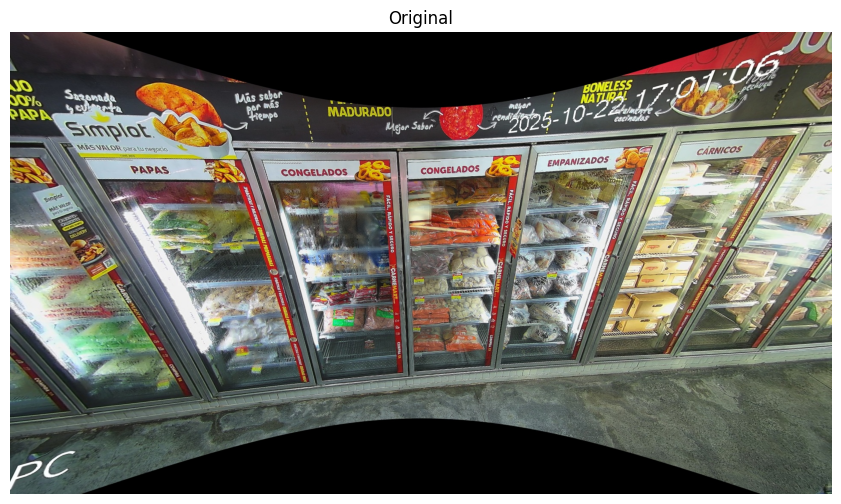

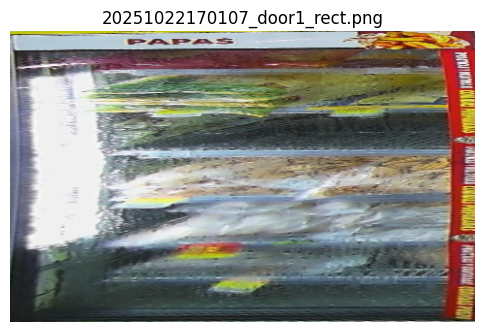

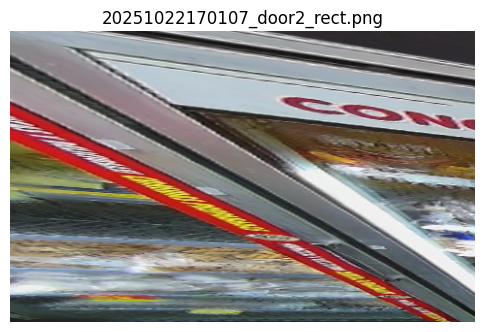

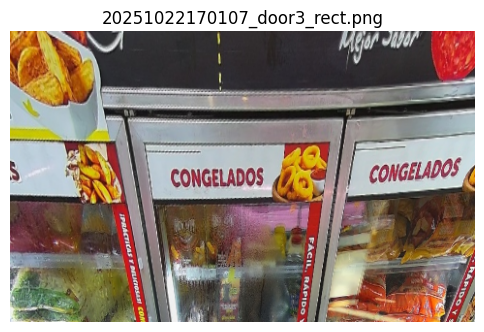

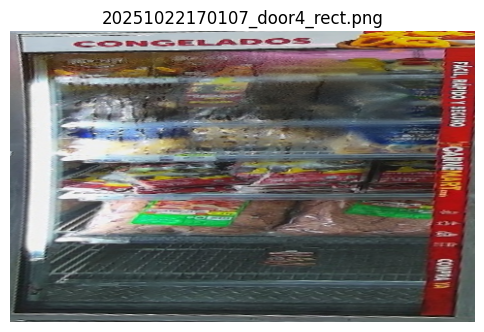

Rectificaciones guardadas en: /content/drive/MyDrive/Maestria/Proyecto integrador/Proyecto IA: Anaqueles frios/Data/detectron2_keypointrcnn/rectified


['/content/drive/MyDrive/Maestria/Proyecto integrador/Proyecto IA: Anaqueles frios/Data/detectron2_keypointrcnn/rectified/20251022170107_door1_rect.png',
 '/content/drive/MyDrive/Maestria/Proyecto integrador/Proyecto IA: Anaqueles frios/Data/detectron2_keypointrcnn/rectified/20251022170107_door2_rect.png',
 '/content/drive/MyDrive/Maestria/Proyecto integrador/Proyecto IA: Anaqueles frios/Data/detectron2_keypointrcnn/rectified/20251022170107_door3_rect.png',
 '/content/drive/MyDrive/Maestria/Proyecto integrador/Proyecto IA: Anaqueles frios/Data/detectron2_keypointrcnn/rectified/20251022170107_door4_rect.png']

In [ ]:
RECT_OUT = os.path.join(OUT_DIR, "rectified")
os.makedirs(RECT_OUT, exist_ok=True)

def rectify_door(img_bgr, kps4, out_w=480, out_h=300):
    pts1 = np.float32([[kps4[0,0], kps4[0,1]],
                       [kps4[1,0], kps4[1,1]],
                       [kps4[2,0], kps4[2,1]],
                       [kps4[3,0], kps4[3,1]]])
    pts2 = np.float32([[0,0],[out_w,0],[out_w,out_h],[0,out_h]])
    M = cv2.getPerspectiveTransform(pts1, pts2)
    return cv2.warpPerspective(img_bgr, M, (out_w, out_h))

def infer_and_rectify(image_path, predictor, max_doors=4, out_w=480, out_h=300):
    img = cv2.imread(image_path)
    out = predictor(img)
    inst = out["instances"].to("cpu")
    if not inst.has("pred_keypoints") or len(inst) == 0:
        print("No detections.")
        return []

    pred_kps = inst.pred_keypoints.numpy()

    order = np.argsort(pred_kps[:,:,0].mean(axis=1))
    pred_kps = pred_kps[order][:max_doors]

    base = os.path.splitext(os.path.basename(image_path))[0]
    saved = []
    for i in range(len(pred_kps)):
        rect = rectify_door(img, pred_kps[i], out_w=out_w, out_h=out_h)
        p = os.path.join(RECT_OUT, f"{base}_door{i+1}_rect.png")
        cv2.imwrite(p, rect)
        saved.append(p)

    plt.figure(figsize=(12,6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis("off")
    plt.show()

    for p in saved:
        r = cv2.imread(p)
        plt.figure(figsize=(6,4))
        plt.imshow(cv2.cvtColor(r, cv2.COLOR_BGR2RGB))
        plt.title(os.path.basename(p))
        plt.axis("off")
        plt.show()

    print("Rectificaciones guardadas en:", RECT_OUT)
    return saved

sample = (val_records[1]["file_name"] if len(val_records) else train_records[0]["file_name"])
infer_and_rectify(sample, predictor, max_doors=4)